In [1]:
suppressMessages(library(dplyr))
suppressMessages(library(data.table))
suppressMessages(library(ggplot2))
suppressMessages(library(Cairo))

In [2]:
summary <- fread('summary_sorted.dat')

In [3]:
summary$cv.qval <- p.adjust(summary$cv.pval, method='fdr')

In [4]:
head(summary)

file,coeffs,cv.rsq,cv.pval,ensg,cv.qval
EUR.ENSG00000198502.wgt.RDat,114,0.7356103,2.322327e-160,ENSG00000198502,1.977230e-156
EUR.ENSG00000204310.wgt.RDat,60,0.7130527,1.252123e-150,ENSG00000204310,5.330288e-147
EUR.ENSG00000236104.wgt.RDat,45,0.6829610,8.961344e-139,ENSG00000236104,2.543229e-135
EUR.ENSG00000204536.wgt.RDat,66,0.6675997,3.778735e-133,ENSG00000204536,8.043037e-130
EUR.ENSG00000223501.wgt.RDat,66,0.6616691,4.784117e-131,ENSG00000223501,8.146394e-128
EUR.ENSG00000231925.wgt.RDat,72,0.6595613,2.619389e-130,ENSG00000231925,3.716913e-127


# Plot of cv.pval distribution

png 
  2

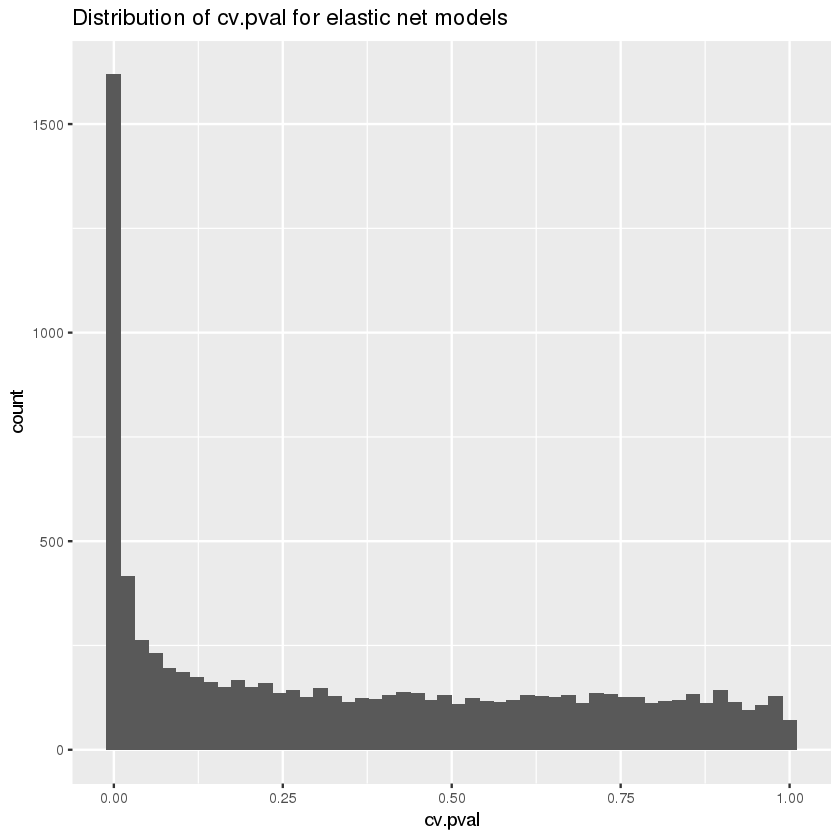

In [5]:
CairoPNG(width=640, height=480, file='tcga-brca_enet_models_pval_distribution2.png')
ggplot(data=summary, aes(summary$cv.pval)) + geom_histogram(bins=50) + labs(x='cv.pval', title='Distribution of cv.pval for elastic net models')
dev.off()

# Plot of cv.qval distribution

png 
  2

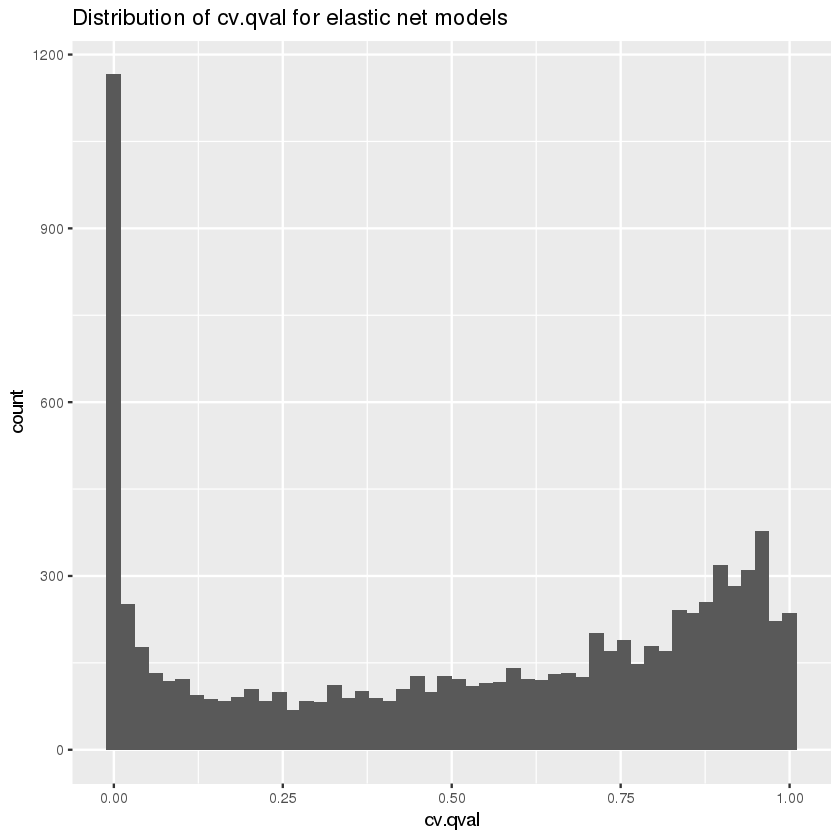

In [6]:
CairoPNG(width=640, height=480, file='tcga-brca_enet_models_qval_distribution2.png')
ggplot(data=summary, aes(summary$cv.qval)) + geom_histogram(bins=50) + labs(x='cv.qval', title='Distribution of cv.qval for elastic net models')
dev.off()

# QQ plot of cv.pvals

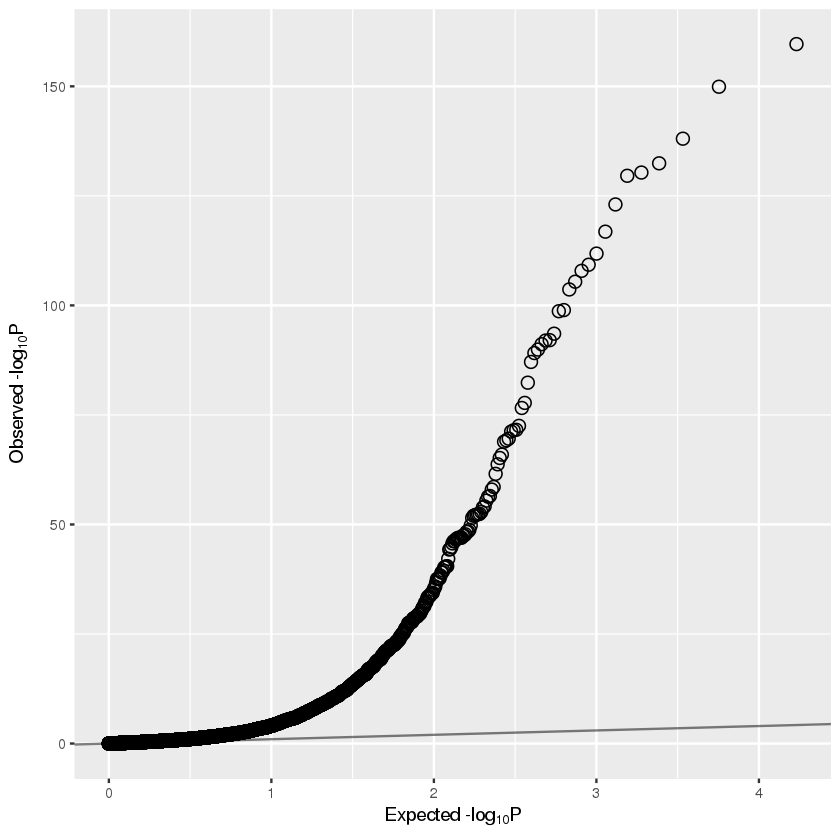

In [7]:
CairoPNG(width=640, height=640, file='tcga-brca_enet_models_qqplot2.png')
qq_df <- data.frame(observed=-log10(summary$cv.pval),expected=-log10(ppoints(length(summary$cv.pval))))
log10Pe <- expression(paste("Expected -log"[10], plain(P)))
log10Po <- expression(paste("Observed -log"[10], plain(P)))
ggplot(qq_df) + geom_point(aes(expected, observed), shape = 1, size = 3) +
geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
xlab(log10Pe) + ylab(log10Po)

# Filter for $q<0.1$

In [8]:
# filter for qval<0.1
significant_models <- filter(summary, cv.qval<=0.1)
write.table(significant_models, 'tcga-brca_enet_models_significant_qval.txt', sep='\t', row.names=F, quote=F)

In [9]:
dim(significant_models)

[1] 1882    6

# Scatterplot of number of nonzero coefficients vs. rsq

png 
  2

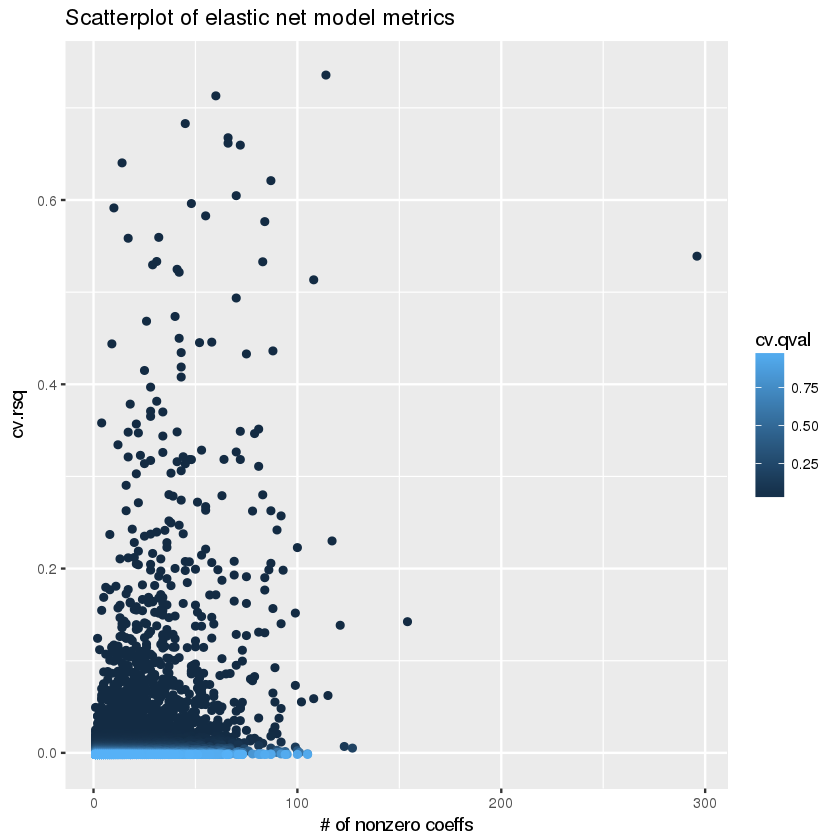

In [10]:
CairoPNG(width=640, height=480, file='tcga-brca_models_coeffs_vs_rsq2.png')
ggplot(summary, aes(x=coeffs, y=cv.rsq, color=cv.qval)) + geom_point() + 
labs(x='# of nonzero coeffs', y='cv.rsq', title='Scatterplot of elastic net model metrics')
dev.off()

png 
  2

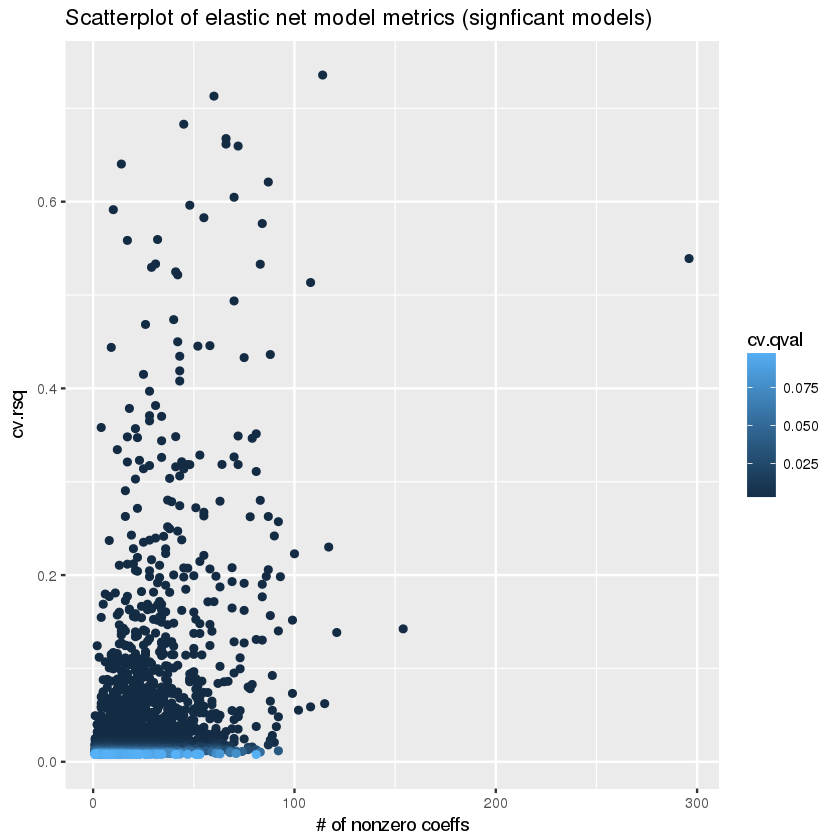

In [11]:
CairoPNG(width=640, height=480, file='tcga-brca_models_coeffs_vs_rsq_significant2.png')
ggplot(significant_models, aes(x=coeffs, y=cv.rsq, color=cv.qval)) + geom_point() + 
labs(x='# of nonzero coeffs', y='cv.rsq', title='Scatterplot of elastic net model metrics (signficant models)')
dev.off()

# Subset test data expression matrix to the genes with $q<0.1$ for which we will be doing predictions

In [14]:
test_expr <- fread('/data/cellardata/users/jlz014/TCGA/expression/TCGA-BRCA.ENSG.chr1-22.median-filt.log2RPKM.qnorm.test.txt')
significant_genes <- significant_models$ensg

In [16]:
test_expr_significant_genes <- filter(test_expr, gene %in% significant_genes)

In [18]:
head(test_expr_significant_genes)

gene,chr,start,end,TCGA-OL-A5RZ,TCGA-C8-A27A,TCGA-BH-A2L8,TCGA-AR-A5QP,TCGA-E9-A1RE,TCGA-S3-AA0Z,⋯,TCGA-AC-A3EH,TCGA-A2-A0YD,TCGA-D8-A1XB,TCGA-E9-A24A,TCGA-E9-A3X8,TCGA-A2-A0EY,TCGA-A8-A07W,TCGA-D8-A27V,TCGA-A1-A0SI,TCGA-C8-A12T
ENSG00000002016,12,1034628,1042224,0.3041519,-1.4841488,-1.97916383,0.122465384,0.1509217,1.52045215,⋯,0.46754156,-0.3750929,0.23350383,0.23954351,-1.6619025,0.6990255,0.03994753,-0.7603460,-1.75264708,-0.54636183
ENSG00000002587,4,11401381,11430221,-0.4978969,-2.9876165,-0.17711389,0.614486191,-0.6287358,1.44970243,⋯,-1.36141266,0.7572131,-1.30156636,0.53955598,-1.0226640,-0.3700568,0.60882125,-1.4912532,0.52467008,0.07995894
ENSG00000003393,2,202593340,202603447,0.1390514,0.9724351,0.39025920,-0.782489595,-0.2371266,0.04935386,⋯,0.43890411,0.6258758,0.84799885,0.13905137,-2.5652793,0.8821523,0.62873582,0.8769642,-0.24801382,-1.24096026
ENSG00000004455,1,33489720,33502469,-3.3087284,0.2710965,-0.05758795,0.008222397,-0.9263497,-0.39279557,⋯,-0.51391672,0.4324463,0.09410792,-0.07406841,-0.6620077,-0.9667966,0.14379705,1.0735229,0.48200388,-0.04935386
ENSG00000005801,11,3392209,3400384,1.4841488,1.7863700,-0.45057463,-0.896104763,0.9390524,0.56417719,⋯,-1.57491322,-0.2154348,0.69902552,0.95561065,-1.2988312,-0.1556757,1.81003387,-0.5669338,0.16995926,0.38645934
ENSG00000005961,17,42461688,42463177,1.7526471,-0.1938440,-0.09292816,0.266225423,0.9649239,0.74475496,⋯,-0.04935386,-0.4965677,0.23471108,-0.68114054,0.9209512,0.1747280,0.93540765,-1.9020116,0.05641142,1.04877207


In [19]:
write.table(test_expr_significant_genes, file='/data/cellardata/users/jlz014/TCGA/expression/TCGA-BRCA.ENSG.chr1-22.median-filt.log2RPKM.qnorm.test.for_predictions.txt',sep='\t', quote=F, row.names=F)